In [1]:
#Sun and VF only, NO tunnel
#testing in flies can see VF when other lights are ON
#all LEDs in led strip ON, at different intensities
#VF always moving at some set speed and direction
#filter from panels removed, magnets painted black
#same experiment as VD_012420

In [2]:
#import packages
import numpy as np
import copy
import pandas
import os
import imp
import pickle
from scipy.interpolate import interp1d
import warnings
import time
import matplotlib.pyplot as plt
import inspect
import types
import math as mat
import seaborn as sns
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm
import datetime
from matplotlib import animation
from IPython.display import HTML
from tempfile import NamedTemporaryFile
import matplotlib.backends.backend_pdf
from scipy import interpolate
from itertools import groupby
import re
import csv
import copy
from fnmatch import fnmatch
import json
import h5py 
import copy
import math
import sys
import itertools
pi = math.pi

sys.path.append("/Users/fponce/Documents/vdesert/vdesert_funcs/") 

sns.set()
sns.set_style()
%matplotlib inline

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
import import_funcs.vdesert_functions as ff #francesca functions (ff)

In [4]:
#ledpanels

def get_pattern_speed(patterns_idx, patterns_dith_levels, pattern_id, gain):
    dith_level = patterns_dith_levels[pattern_id-1]
    speed = gain/dith_level
    return speed

#alicat, wind flow

def read_in_wind_flow_parameters(alicat_devices_topic):
#read in and strip the alicat message
#returns the 
    allmsg = str(alicat_devices_topic)
    allmsg_line = allmsg.split('\\n')
    
    allmsg_split = []
    for i in allmsg_line:
        msg_split = str(i).split(':')
        allmsg_split.append(msg_split)
    
    allmsg_stripped = []
    for i in allmsg_split:
        allmsg_pairs = []
        for j in i:
            msg_stripped = str(j).strip('    ')
            allmsg_pairs.append(msg_stripped)    
        allmsg_stripped.append(allmsg_pairs)
    
    return allmsg_stripped

def get_alicat_parameters(allmsg_stripped):
    
    n = 2 #number of addresses (or devices)
    
    #getting addresses
    adresses_file = []
    alicat_seq_file = []
    rate_set_point_file = []
    rate_actual_file = []
    success_file = []
    for i in range(len(allmsg_stripped)):
        for j in range(len(allmsg_stripped[i])):
            if allmsg_stripped[i][j] == 'address':
                adresses_file.append(allmsg_stripped[i][1][1])
            elif allmsg_stripped[i][j] == 'seq':
                alicat_seq_file.append(int(allmsg_stripped[i][1]))
            elif allmsg_stripped[i][j] == 'rate_set_point':
                rate_set_point_file.append(float(allmsg_stripped[i][1]))  
            elif allmsg_stripped[i][j] == 'rate_actual':
                rate_actual_file.append(float(allmsg_stripped[i][1]))   
            elif allmsg_stripped[i][j] == 'success':
                success_file.append((allmsg_stripped[i][1])) 
           
    adresses_file_dev = [adresses_file[x:x+n] for x in range(0, len(adresses_file),n)]
    rate_set_point_file_dev = [rate_set_point_file[x:x+n] for x in range(0, len(rate_set_point_file),n)]
    rate_actual_file_dev = [rate_actual_file[x:x+n] for x in range(0, len(rate_actual_file),n)]
    success_file_dev = [success_file[x:x+n] for x in range(0, len(success_file),n)]
    
    lists_to_check = [adresses_file_dev, rate_set_point_file_dev, rate_actual_file_dev, success_file_dev]
    
    for i in lists_to_check:
        for j in i:
            if len(j) != n:
                raise Exception('something is wrong with msg')
            
    for i in lists_to_check:
        if len(i) != len(alicat_seq_file):
            raise Exception('something is wrong with msg')  
            
    return alicat_seq_file, adresses_file_dev, rate_set_point_file_dev, rate_actual_file_dev, success_file_dev

def get_changes_set_point(rate_set_point_file):
    idx_changes_set_point_l = []
    for i in range(len(rate_set_point_file)-1):
        if i == 0 :
            idx = i
        elif rate_set_point_file[i] != rate_set_point_file[i+1]:
            idx = i+1
        elif i == len(rate_set_point_file)-2:
            idx = i+1 
        idx_changes_set_point_l.append(idx)
        
    idx_changes_set_point = np.unique(np.asarray(idx_changes_set_point_l))
    
    return idx_changes_set_point

def get_consecutive_pairs(myarray):
    start_frames = []
    end_frames = []
    for i in range(len(myarray)-1):
        s = myarray[i]
        e = myarray[i + 1]  
        start_frames.append(s)
        end_frames.append(e)
    return start_frames, end_frames

In [5]:
#functions

#basic operation functions

flatten = lambda l: [item for sublist in l for item in sublist]

################################################################

def get_it_wrapped (myangle_array):
    all_angles = []
    for a in np.deg2rad(myangle_array):
        while a < pi:
            a += 2 * pi
        while a > pi:
            a -= 2 * pi
        all_angles.append(np.rad2deg(a))
    return all_angles

def get_elapsed_time(my_list):
#for list of lists
    all_t_ellapsed = []
    for i in range(len(my_list)):
        t_ellapsed = my_list[i] - my_list[i][0]
        all_t_ellapsed.append(t_ellapsed)
    return all_t_ellapsed

def smallestSignedAngleBetween(x, y):
    a = math.atan2(math.sin(y-x), math.cos(y-x))
    return a

def get_smallestSignedAngleBetween(ax, y):
    #for arrays! ax is the array
    yy=np.deg2rad(np.ones(len(ax))*y)
    axx = np.deg2rad(ax)
    
    array_smallestsignedangle = []
    for k in range(len(ax)):
        kk = smallestSignedAngleBetween(axx[k], yy[k])*-1
        kk = (np.rad2deg(kk))
        array_smallestsignedangle.append(kk)
    
    return array_smallestsignedangle

def circmean(alpha,axis=None):
    mean_angle = np.arctan2(np.mean(np.sin(alpha),axis),np.mean(np.cos(alpha),axis))
    return mean_angle

def circvar(alpha,axis=None):
#### vector strength = 1 - circvar
#     if np.ma.isMaskedArray(alpha) and alpha.mask.shape!=():
#         N = np.sum(~alpha.mask,axis)
#     else:
#         if axis is None:
#             N = alpha.size
#         else:
#             N = alpha.shape[axis]
    R = np.sqrt(np.sum(np.sin(alpha),axis)**2 + np.sum(np.cos(alpha),axis)**2)/len(alpha)
    V = 1-R
    return R

In [6]:
#experiment info

exp = 'VD_0212420'

dataDir = '/Users/fponce/Documents/vdesert/temp'
pattern_vdesert_data = "*.hdf5"

################################################################################################

#importing ledpanels patterns info saved in the card
pattern_table_path = '/Users/fponce/Documents/vdesert/VDesert_patterns_110619.csv'
pattern_table = pandas.read_csv(pattern_table_path) 
patterns_idx = pattern_table.iloc[:,0].tolist()
patterns_angles = pattern_table.iloc[:,1].tolist()
patterns_dith_levels = pattern_table.iloc[:,2].tolist()

################################################################################################

#sunleds ids

n_sunleds = 143+1
sunleds = np.arange(1,n_sunleds,1)
sunleds_angles_unwrapped = (sunleds * (360/143)- (360/143))
sunleds_angless = get_it_wrapped(sunleds_angles_unwrapped)

sunleds_angless_1 = np.flip(sunleds_angless[0:int(143/2)],0)
sunleds_angless_2 = np.flip(sunleds_angless[int(143/2)+1:],0)

sunleds_angless_12 = [sunleds_angless_1, sunleds_angless_2]

sunleds_angles_12 = list(itertools.chain(*sunleds_angless_12))
led_ids_angles = copy.deepcopy(sunleds_angles_12)
led_ids_angles.insert(0,'NaN')

################################################################################################

#for magnotether angle interpolation

time_each_test_trials = [60,60,60,60,10]
time_each_trial_trials = [180,10,180,180,180,180,180]

time_each_trial = []
time_each_trial.append(time_each_test_trials)
time_each_trial.append(time_each_trial_trials)

time_each_trial = flatten(time_each_trial)

number_trials = len(time_each_trial)
experiment_time = np.sum(np.asarray(time_each_trial))
number_frames_per_sec = 30

print(str(experiment_time)+' secs')
print(str(experiment_time*30)+ ' frames')

################################################################################################

#alicat
#alicat_addresses: ['A', 'F']
#alicat_addresses: ['pulling', 'pushing']

################################################################################################

#import data
datapaths = []
for path, subdirs, files in os.walk(dataDir):
    for name in files:
        if fnmatch(name, pattern_vdesert_data):
            datapaths.append(os.path.join(path, name))

print(str(len(datapaths))+' files')

################################################################################################

#check for keys
# for i in range(len(datapaths)):
#     f = h5py.File(datapaths[i], "r")
#     datasetNames = [n for n in f.keys()]
#print(datasetNames)

1340 secs
40200 frames
23 files


In [7]:
#hdf5 -> np.arrays
all_params_ts = []
all_data_params = []

all_ros_ts = []
all_ts = []
all_elapsed_time = []
all_trial_index = []
all_trial_elapsed_time = []
all_angle_for_autostep = []
all_init_angle = []
all_autostep_running = []
all_autostep_started = []
all_autostep_stopped = []
all_flow_running = []
all_flow_started = []
all_flow_stopped = []
all_panels_running = []
all_panels_started = []
all_panels_stopped = []

all_magnotether_angle = []
all_magnotether_ros_tstamps = []
all_magnotether_tstamps = []

all_motion_ros_tstamps = []
all_motion_tstamps = []
all_motion_setpoint = []
all_motion_position = []

all_ledpanels_ros_tstamps = []
all_ledpanels_command = []
all_ledpanels_1 = []
all_ledpanels_2 = []
all_ledpanels_3 = []
all_ledpanels_4 = []
all_ledpanels_5 = []
all_ledpanels_6 = []

all_alicat_ros_tstamps = []
all_alicat_devices = []

all_sun_ros_tstamps = []
all_sun_red = []
all_sun_green = []
all_sun_blue = []
all_sun_message = []
all_sun_led_number = []

for i in range(len(datapaths)):
    f = h5py.File(datapaths[i], "r")
    
    #parameters topic
#     params_ts = np.asarray(f['data_params_ros_tstamps'])
#     data_params = np.asarray(f['data_params'])
    
    #virtual_desert topic
    ros_ts = np.asarray(f['ros_tstamps'])
    ts = np.asarray(f['tstamps'])
    elapsed_time = np.asarray(f['elapsed_time'])
    trial_index = np.asarray(f['current_trial_index'])
    trial_elapsed_time = np.asarray(f['trial_e_time'])
    angle_for_autostep = np.asarray(f['angle'])
    init_angle = np.asarray(f['init_angle'])
    
    #actions
    autostep_running = np.asarray(f['autostep_action_running'])
    autostep_started = np.asarray(f['autostep_action_started'])
    autostep_stopped = np.asarray(f['autostep_action_stopped'])
    
    flow_running = np.asarray(f['flow_action_running'])
    flow_started = np.asarray(f['flow_action_started'])
    flow_stopped = np.asarray(f['flow_action_stopped'])  
    
    panels_running = np.asarray(f['panels_action_running'])
    panels_started = np.asarray(f['panels_action_started'])
    panels_stopped = np.asarray(f['panels_action_stopped'])      
    
    #magnotether_angle topic
    magnotether_angle = np.asarray(f['magnotether_angle'])
    magnotether_ros_tstamps = np.asarray(f['magnotether_ros_tstamps'])
    magnotether_tstamps = np.asarray(f['magnotether_tstamps'])
    
    #motion_data topic
    motion_ros_tstamps = np.asarray(f['motion_data_ros_tstamps'])
    motion_tstamps = np.asarray(f['motion_data_tstamps'])
    motion_setpoint = np.asarray(f['motion_data_setpoint'])
    motion_position = np.asarray(f['motion_data_position'])
    
    #ledpanels topic
    ledpanels_ros_tstamps = np.asarray(f['ledpanels_ros_tstamps'])
    ledpanels_command = np.asarray(f['ledpanels_panels_command'])
    ledpanels_1 = np.asarray(f['ledpanels_panels_arg1'])
    ledpanels_2 = np.asarray(f['ledpanels_panels_arg2'])
    ledpanels_3 = np.asarray(f['ledpanels_panels_arg3'])
    ledpanels_4 = np.asarray(f['ledpanels_panels_arg4']) 
    ledpanels_5 = np.asarray(f['ledpanels_panels_arg5']) 
    ledpanels_6 = np.asarray(f['ledpanels_panels_arg6']) 
    
    #alicat topic
    alicat_ros_tstamps = np.asarray(f['alicat_ros_tstamps'])
    alicat_devices = np.asarray(f['alicat_devices'])
    
    #sun topic
    sun_ros_tstamps = np.asarray(f['sun_ros_tstamps'])
    sun_red = np.asarray(f['sun_red'])
    sun_green = np.asarray(f['sun_green'])
    sun_blue = np.asarray(f['sun_blue'])
    sun_message = np.asarray(f['sun_message'])
    sun_led_number = np.asarray(f['sun_led_number'])
    
#     all_params_ts.append(params_ts)
#     all_data_params.append(data_params)

    all_ros_ts.append(ros_ts)
    all_ts.append(ts)
    all_elapsed_time.append(elapsed_time)
    all_trial_index.append(trial_index)
    all_trial_elapsed_time.append(trial_elapsed_time)
    all_angle_for_autostep.append(angle_for_autostep)
    all_init_angle.append(init_angle)
    all_autostep_running.append(autostep_running)
    all_autostep_started.append(autostep_started)
    all_autostep_stopped.append(autostep_stopped)
    all_flow_running.append(flow_running)
    all_flow_started.append(flow_started)
    all_flow_stopped.append(flow_stopped)
    all_panels_running.append(panels_running)
    all_panels_started.append(panels_started)
    all_panels_stopped.append(panels_stopped)
    all_magnotether_angle.append(magnotether_angle)
    all_magnotether_ros_tstamps.append(magnotether_ros_tstamps)
    all_magnotether_tstamps.append(magnotether_tstamps)
    all_motion_ros_tstamps.append(motion_ros_tstamps)
    all_motion_tstamps.append(motion_tstamps)
    all_motion_setpoint.append(motion_setpoint)
    all_motion_position.append(motion_position)
    all_ledpanels_1.append(ledpanels_1)
    all_ledpanels_2.append(ledpanels_2)
    all_ledpanels_3.append(ledpanels_3)
    all_ledpanels_4.append(ledpanels_4)
    all_ledpanels_5.append(ledpanels_5)
    all_ledpanels_6.append(ledpanels_6)
    all_ledpanels_command.append(ledpanels_command)
    all_ledpanels_ros_tstamps.append(ledpanels_ros_tstamps)
    all_alicat_ros_tstamps.append(alicat_ros_tstamps)
    all_alicat_devices.append(alicat_devices)   
    all_sun_ros_tstamps.append(sun_ros_tstamps)
    all_sun_red.append(sun_red)
    all_sun_green.append(sun_green)
    all_sun_blue.append(sun_blue)
    all_sun_led_number.append(sun_led_number)

In [8]:
#quick check for flies that completed all the trials

# for i in range(len(datapaths)):
#     print(np.unique(all_trial_index[i]))
    
# #quick look at  magnotether data
# for i in range(len(all_magnotether_angle)):
#     plt.figure(figsize = (25,5))
#     plt.plot(all_magnotether_angle[i])
#     plt.title(datapaths[i])

In [9]:
# get start and end trials basic operations/should work for all files/experiments

#this gets the start and end times and frames(all_elapsed_time) 
#when the trial changes in the virtual desert node

all_start_frames, all_end_frames = ff.get_all_trial_start_n_end_frames(datapaths, 
                                                                       number_trials, 
                                                                       all_trial_index)

all_start_times, all_end_times = ff.get_all_trial_start_n_end_times(datapaths, 
                                                                    number_trials, 
                                                                    all_elapsed_time, 
                                                                    all_trial_index)
print(str(len(all_start_frames[0]))+' start times/frames')

##########################################################################################
#interpolation of magnotether angles

t = [0, experiment_time]
reg_t = np.linspace(t[0], t[-1],(experiment_time*number_frames_per_sec)+1)

#getting elapsed time of time stamps to use
all_ts = get_elapsed_time(all_magnotether_ros_tstamps)

all_magnotether_interp_angles = ff.get_all_magnotether_interp_angles (all_magnotether_angle, 
                                                                      all_ts, 
                                                                      reg_t)

##########################################################################################
#get the closest times that correspond to start and end times in the reg_t

all_start_times_m, all_end_times_m = ff.get_start_n_end_times_m (all_start_times, all_end_times, reg_t)
all_start_frames_m, all_end_frames_m = ff.get_start_n_end_frames_m (all_start_times, all_end_times, reg_t)

##########################################################################################
#get start frames for last minute and end frames first min

all_start_frames_m_lm, all_end_frames_m_fm = ff.get_first_n_last_minute_trial (all_start_frames_m, all_end_frames_m, number_frames_per_sec)

12 start times/frames


In [10]:
## get ledpanels info basic operations/should work for all files/experiments

#get elapsed time of panels
all_ledpanels_elapsed_t = get_elapsed_time(all_ledpanels_ros_tstamps)

##########################################################################################

#gets the indeces of the set pattern id command
all_idx_pat_command = []
all_idx_gain_command = []
all_idx_stop_command = []
for i in range(len(datapaths)):
    idx_pat_command, idx_gain_command, idx_stop_command= ff.get_idx_panels_commands(all_ledpanels_command[i])
    all_idx_pat_command.append(idx_pat_command)
    all_idx_gain_command.append(idx_gain_command)
    all_idx_stop_command.append(idx_stop_command)
    
#get elapsed time of panels
all_ledpanels_elapsed_t = get_elapsed_time(all_ledpanels_ros_tstamps)

##########################################################################################

#get times when ledpanels node sent a gain command
all_ledpanels_elapsed_t_gain  = []
for i in range(len(all_idx_gain_command)):
    ledpanels_elapsed_t_gain = []
    for j in range(len(all_idx_gain_command[i])):
        t = all_ledpanels_elapsed_t[i][all_idx_gain_command[i][j]]
        ledpanels_elapsed_t_gain.append(t)
    all_ledpanels_elapsed_t_gain.append(ledpanels_elapsed_t_gain)

##########################################################################################

#get times when ledpanels node sent a stop command
all_ledpanels_elapsed_t_stop  = []
for i in range(len(all_idx_stop_command)):
    ledpanels_elapsed_t_stop = []
    for j in range(len(all_idx_stop_command[i])):
        t = all_ledpanels_elapsed_t[i][all_idx_stop_command[i][j]]
        ledpanels_elapsed_t_stop.append(t)
    all_ledpanels_elapsed_t_stop.append(ledpanels_elapsed_t_stop)

##########################################################################################

#get arg1 for pannel_id command and gains
#get the arg1 for the rows of pattern_id command
all_pattern_id = []
for i in range(len(all_idx_pat_command)):
    pattern_id_file = []
    for j in (all_idx_pat_command[i]):
        arg1 = all_ledpanels_1[i][j]
        pattern_id_file.append(arg1)
    all_pattern_id.append(pattern_id_file)

##########################################################################################

#get the arg1 for the rows of gain command
all_gains = []
for i in range(len(all_idx_gain_command)):
    gains_file = []
    for j in (all_idx_gain_command[i]):
        arg1 = all_ledpanels_1[i][j]
        gains_file.append(arg1)
    all_gains.append(gains_file)

print('gains first file:')
print(all_gains[0])

##########################################################################################

# get the corresponding angles from the pattern_ids
all_pat_angles = []
for i in range(len(all_pattern_id)):
    pat_angles_file = []
    for j in range(len(all_pattern_id[i])):
        p = patterns_angles[all_pattern_id[i][j]-1]# -1 bc pattern id start at 1
        pat_angles_file.append(p)
    all_pat_angles.append(pat_angles_file)

#get the speeds in pixels/sec
#depending the number of intensities used to dither patterns, 
#these will move at different speeds when set at the same gain. 
#This function just gets the speed in pixels/sec from the gain 
#and the pattern_id. It needs a table to read this from. 

all_speeds = []
for i in range(len(all_gains)):
    speeds_per_file = []
    for j in range(len(all_gains[i])):
        s = get_pattern_speed(patterns_idx, patterns_dith_levels, all_pattern_id[i][j], all_gains[i][j])
        speeds_per_file.append(s)
    all_speeds.append(speeds_per_file)
    
print('speeds first file:')
print(all_speeds[0])

gains first file:
[40, 40, 40, 40, 32, 0, 0, 32, 32]
speeds first file:
[10.0, 10.0, 10.0, 10.0, 8.0, 0.0, 0.0, 8.0, 8.0]


In [11]:
# #needs to be cleaned up!
# #get wind flow info

# #get alicat parameters
# all_alicat_seq = []
# all_adresses = []
# all_rate_set_point = []
# all_rate_actual = []
# all_success = []

# for i in range(len(all_alicat_devices)):
#     msg = read_in_wind_flow_parameters(all_alicat_devices[i])
#     seq, adresses, rate_set_point, rate_actual, success = get_alicat_parameters(msg)

#     all_alicat_seq.append(seq)
#     all_adresses.append(adresses)
#     all_rate_set_point.append(rate_set_point)
#     all_rate_actual.append(rate_actual)
#     all_success.append(success)
    
# #get the elapsed time for alicat topic
# all_alicat_elapsed_time = get_elapsed_time(all_alicat_ros_tstamps)

# #find nearest alicat elapsed times to the vdesert start times
# all_start_times_a = []    
# all_end_times_a = []   
# for i in range(len(all_start_times)): 
#     start_times_trials_a = []
#     end_times_trials_a = []    
#     for j in range((number_trials)):
#         start_times_a = find_nearest(all_alicat_elapsed_time[i], all_start_times_m[i][j])
#         end_times_a = find_nearest(all_alicat_elapsed_time[i], all_end_times_m[i][j])
#         start_times_trials_a.append(start_times_a)
#         end_times_trials_a.append(end_times_a)
#     all_start_times_a.append(start_times_trials_a)    
#     all_end_times_a.append(end_times_trials_a)     

# #find nearest alicat elapsed times to the vdesert start times
# all_start_frames_a = []    
# all_end_frames_a = []   
# for i in range(len(all_start_times)): 
#     start_frames_trials_a = []
#     end_frames_trials_a = []    
#     for j in range((number_trials)):
#         start_frames_a = find_nearest_idx(all_alicat_elapsed_time[i], all_start_times_m[i][j])
#         end_frames_a = find_nearest_idx(all_alicat_elapsed_time[i], all_end_times_m[i][j])
#         start_frames_trials_a.append(start_frames_a)
#         end_frames_trials_a.append(end_frames_a)
#     all_start_frames_a.append(start_frames_trials_a)    
#     all_end_frames_a.append(end_frames_trials_a)     
    
# #get the set points at each trial
# all_alicat_set_points = []
# for i in range(len(all_start_frames_a)):
#     alicat_set_points_trials = []
#     for j in all_start_frames_a[i]:
#         #the +1 is just to make sure I am getting the set point for that 
#         #specific trial and avoid errors due to little delays
#         #actual_set_points will give the ACTUAL value
#         alicat_set_points_trials.append(all_rate_set_point[i][j+1][0])
#     all_alicat_set_points.append(alicat_set_points_trials)

# #get the ACTUAL set points at each trial
# all_alicat_actual_set_points = []
# for i in range(len(all_start_frames_a)):
#     alicat_actual_set_points_trials = []
#     for j in range(len(all_start_frames_a[i])):
#         alicat_actual_set_points_trials.append(all_rate_actual[i][all_start_frames_a[i][j]:all_end_frames_a[i][j]])
#     all_alicat_actual_set_points.append(alicat_actual_set_points_trials)
    
# print(all_alicat_set_points)

In [12]:
############################################################################################
###################################### exp dependant #######################################
############################################################################################  

In [13]:
#exp dependant!
#temp fix
#Because one of the trials is dark and there is no pattern_id
#or gain for that trial:

#list of patterns
lp_to_lpvdesert = [0,1,2,3,'NaN',4,'NaN',5,6,7,7,8]

all_pat_angles_vd = []
for i in range(len(all_pat_angles)):
    lp_vd = []
    for j in range(len(lp_to_lpvdesert)):
        try:
            lp = all_pat_angles[i][lp_to_lpvdesert[j]]
        except:
            lp = 'NaN'
        lp_vd.append(lp)
    all_pat_angles_vd.append(lp_vd)


all_speeds_vd = []
for i in range(len(all_speeds)):
    lp_vd = []
    for j in range(len(lp_to_lpvdesert)):
        try:
            lp = all_speeds[i][lp_to_lpvdesert[j]]
        except:
            lp = 'NaN'
        lp_vd.append(lp)
    all_speeds_vd.append(lp_vd)

print(all_speeds[0])
print(all_pat_angles_vd[0])

print(all_speeds_vd[0])

[10.0, 10.0, 10.0, 10.0, 8.0, 0.0, 0.0, 8.0, 8.0]
[90, -90, 0, 180, 'NaN', -45, 'NaN', 90, 45, 45, 45, 0]
[10.0, 10.0, 10.0, 10.0, 'NaN', 8.0, 'NaN', 0.0, 0.0, 8.0, 8.0, 8.0]


In [14]:
#exp dependant!
#Sun start time and end times are a bit of a mess
# because there are only commands to turn sunleds ON and not OFF
#When sun is OFF the command led_id = 0, and intensity = [0,0,0]\

all_sun_elapsed = get_elapsed_time(all_sun_ros_tstamps)

# #trial where the drift occurs bc the only command that is sent is the ON for the sun
# start_drift_frame_idx = 8 

In [15]:
#needs cleaning up and make sure it works for drifting
#get the closest vdesert start times in the sun elaspsed time, then grab those led numbers?

# all_start_times_s = []    
# all_end_times_s = []   
# for i in range(len(all_start_times)): 
#     start_times_trials_s = []
#     end_times_trials_s = []    
#     for j in range((number_trials)):
#         start_times_s = ff.find_nearest(all_sun_elapsed[i], all_start_times_m[i][j])
#         end_times_s = ff.find_nearest(all_sun_elapsed[i], all_end_times_m[i][j])
#         start_times_trials_s.append(start_times_s)
#         end_times_trials_s.append(end_times_s)
#     all_start_times_s.append(start_times_trials_s)    
#     all_end_times_s.append(end_times_trials_s)
    
# all_start_frames_s = []    
# all_end_frames_s = []   
# for i in range(len(all_start_times)): 
#     start_frames_trials_s = []
#     end_frames_trials_s = []    
#     for j in range((number_trials)):
#         start_frames_s = ff.find_nearest_idx(all_sun_elapsed[i], all_start_times_m[i][j])
#         end_frames_s = ff.find_nearest_idx(all_sun_elapsed[i], all_end_times_m[i][j])
#         start_frames_trials_s.append(start_frames_s)
#         end_frames_trials_s.append(end_frames_s)
#     all_start_frames_s.append(start_frames_trials_s)    
#     all_end_frames_s.append(end_frames_trials_s)
    
######################################################################################################   

all_sun_led_rgb = []       
for i in range(len(all_start_times)): 
    sun_led_rgb = []  
    for j in range(len(all_sun_led_number[0])):
        led_n = all_sun_led_number[i][j]
        red = all_sun_red[i][j]
        sun_led_rgb.append(red)
    all_sun_led_rgb.append(sun_led_rgb)

all_sun_led_ang = []       
for i in range(len(all_sun_led_rgb)): 
    sun_led_num = []  
    for j in range(len(all_sun_led_rgb[i])):
        led_n = all_sun_led_number[i][j]
        if led_n == -1:
            led_n=0
            sun_led_num.append(led_ids_angles[led_n])
        else:
            sun_led_num.append(led_ids_angles[led_n])
    all_sun_led_ang.append(sun_led_num)

sl_to_slvdesert = [0,1,2,3,4,5,6,7,8,8,9,10]

all_led_angles_vd = []
for i in range(len(all_sun_led_ang)):
    sl_vd = []
    for j in range(len(sl_to_slvdesert)):
        s = all_sun_led_ang[i][sl_to_slvdesert[j]]
        sl_vd.append(s)
    all_led_angles_vd.append(sl_vd)
    
all_sun_led_rgb_vd = []
for i in range(len(all_sun_led_ang)):
    srgb_vd = []
    for j in range(len(sl_to_slvdesert)):
        s = all_sun_led_rgb[i][sl_to_slvdesert[j]]
        srgb_vd.append(s)
    all_sun_led_rgb_vd.append(srgb_vd)
    
# print(all_led_angles_vd)
# print(all_sun_led_rgb_vd)
# print(all_sun_led_rgb)


In [16]:
#get the rolling mean angle (mean heading of the fly)
#during each trial and the pattern_id to know the
#angle at which the fly was moving with respect to the pattern

# all_rmean_headings = []
# for i in range(len(all_start_frames)):
#     rmean_headings_per_file = [ ]
#     for j in range(len(all_start_frames[i])):
#         a = all_init_angle[i][all_start_frames[i][j]]
#         rmean_headings_per_file.append(a)
#     all_rmean_headings.append(rmean_headings_per_file)

# #get the smallest angle between rmean_headings and angle of pattern
# all_ang_dif = []
# for i in range(len(all_rmean_headings)):
#     ang_dif_per_file = []
#     for j in range(len(all_rmean_headings[i])):
#         if all_pat_angles_vd[i][j]=='NaN':
#             ang_dif = 'NaN'
#         else:
#             ang_dif = np.rad2deg(smallestSignedAngleBetween(np.deg2rad(all_rmean_headings[i][j]), 
#                                                  np.deg2rad(all_pat_angles_vd[i][j])))
#         ang_dif_per_file.append(ang_dif)
#     all_ang_dif.append(ang_dif_per_file)

In [17]:
tp = 0

In [18]:
# # #plot and save raw data
# sns.set_style("ticks")
# allangles = all_magnotether_interp_angles

# for i in range(len(datapaths)):
#     # #plot raw normed data
#     fig, axs = plt.subplots(figsize=(30, 60), facecolor='w', edgecolor='k')
#     #fig.tight_layout()
#     fig.suptitle('Experiment '+exp+'\n'+'raw data '+'Fly '+str(i),fontsize = 30, fontweight='bold')
#     fig.subplots_adjust(top=0.94, hspace = .2, bottom=0.05)
    
#     bckclr_labels = ['darkseagreen', 'lavender', 'lightyellow']
    
#     gs = gridspec.GridSpec(7, 2)
    
#     ######################################################################################################   
    
# ##  #control trials (0-3) and dark (4)
#     ax1 = plt.subplot(gs[0, :])
    
#     a = all_start_frames_m[i][0]
#     b = all_end_frames_m[i][0]
#     c = all_start_frames_m[i][1]
#     d = all_end_frames_m[i][1]
#     e = all_start_frames_m[i][2]
#     f = all_end_frames_m[i][2]
#     g = all_start_frames_m[i][3]
#     h = all_end_frames_m[i][3]
#     j = all_start_frames_m[i][4]
#     k = all_end_frames_m[i][4]
    
#     ang_to_plot = allangles[i][a:k] 
    
#     ax1.plot(reg_t[a:k],ang_to_plot,color = 'k')
    
#     ax1.plot((reg_t[a],reg_t[b]), (all_pat_angles_vd[i][0], all_pat_angles_vd[i][0]), 'green', linewidth= 3)
#     ax1.plot((reg_t[c],reg_t[d]), (all_pat_angles_vd[i][1], all_pat_angles_vd[i][1]), 'green', linewidth= 3)
#     ax1.plot((reg_t[e],reg_t[f]), (all_pat_angles_vd[i][2], all_pat_angles_vd[i][2]), 'green', linewidth= 3)
#     ax1.plot((reg_t[g],reg_t[h]), (all_pat_angles_vd[i][3], all_pat_angles_vd[i][3]), 'green', linewidth= 3)
#     ax1.plot((reg_t[j],reg_t[k]), (all_pat_angles_vd[i][4], all_pat_angles_vd[i][4]), 'green', linewidth= 3)
    
#     #plot format
#     ax1.set_title('VF speed = '+str(all_speeds_vd[i][3]), fontsize = 30, fontweight='bold')
#     ax1.set_ylim([-200, 200])
#     ax1.set_xlim([reg_t[a], reg_t[k]])
#     ax1.set_xticks(np.arange(reg_t[a], reg_t[h], 60))
#     ax1.set_yticks(np.arange(-180, 225,45))
#     ax1.yaxis.set_tick_params(labelsize=30)
#     ax1.xaxis.set_tick_params(labelsize=30)
#     #ax1.set_xticklabels((round(all_start_frames[j]/30),round(all_end_frames[j+1]/30)))
#     ax1.axvspan(reg_t[j], reg_t[k], facecolor='lightgray', alpha=1)
#     ax1.patch.set_facecolor(bckclr_labels[0])
#     ax1.patch.set_alpha(0.7)
#     #box, ticks format
#     sns.set_style("ticks")
#     sns.despine()
#     ax1.tick_params(direction='in', length=8, width=2)
#     sns.despine(offset=10, trim=False);
#     ax1.spines['left'].set_linewidth(2)
#     ax1.spines['bottom'].set_linewidth(2)
#     ax1.grid(True,linewidth=2)
    
#     ######################################################################################################
    
# ## #trial 5 
#     t = 5
#     ax2 = plt.subplot(gs[1, :])
    
#     a = all_start_frames_m[i][t]
#     b = all_end_frames_m[i][t]
    
    
#     ang_to_plot = allangles[i][a:b] 
    
#     ax2.plot(reg_t[a:b],ang_to_plot,color = 'k')
#     #optic flow
#     if all_speeds_vd[i][t] == 0:
#         pass
#     else:
#         ax2.plot((reg_t[a],reg_t[b]), (all_pat_angles_vd[i][t], all_pat_angles_vd[i][t]), 'green', linewidth= 4)
#     #wind flow
#     #ax2.plot((reg_t[a],reg_t[b]), (0, 0), 'blue', linewidth= 3)
    
#     #plot format
#     ax2.set_title('VF speed = '+str(all_speeds_vd[i][t]), fontsize = 30, fontweight='bold')
#     #ax2.set_title('LED intensity = '+str(all_sun_led_rgb[i][t]), fontsize = 30, fontweight='bold')
#     ax2.set_ylim([-200, 200])
#     ax2.set_xlim([reg_t[a], reg_t[b]])
#     ax2.set_xticks(np.arange(reg_t[a], reg_t[b], 59))
#     ax2.set_yticks(np.arange(-180, 225,45))
#     ax2.yaxis.set_tick_params(labelsize=30)
#     ax2.xaxis.set_tick_params(labelsize=30)
#     #ax1.set_xticklabels((round(all_start_frames[j]/30),round(all_end_frames[j+1]/30)))
#     #ax2.patch.set_facecolor(bckclr_labels[1])
#     if all_sun_led_rgb_vd[i][t] == 0:
#         ax2.patch.set_facecolor(bckclr_labels[0])
#     elif all_sun_led_rgb_vd[i][t] == 50:
#         ax2.patch.set_facecolor(bckclr_labels[1])
#     else:
#         ax2.patch.set_facecolor(bckclr_labels[2])
        
#     ax2.patch.set_alpha(0.7)
#     #box, ticks format
#     sns.set_style("ticks")
#     sns.despine()
#     ax2.tick_params(direction='in', length=8, width=2)
#     sns.despine(offset=10, trim=False);
#     ax2.spines['left'].set_linewidth(2)
#     ax2.spines['bottom'].set_linewidth(2)
#     ax2.grid(True,linewidth=2) 
    
#     ######################################################################################################
    
# ## #trial 5 and 6 sun only
#     t = 7
#     ax3 = plt.subplot(gs[2, :])
    
#     a = all_start_frames_m[i][t]
#     b = all_end_frames_m[i][t]
    
#     ang_to_plot = allangles[i][a:b] 
    
#     ax3.plot(reg_t[a:b],ang_to_plot,color = 'k')
#     #optic flow
#     if all_speeds_vd[i][t] == 0:
#         pass
#     else:
#         ax3.plot((reg_t[a],reg_t[b]), (all_pat_angles_vd[i][t], all_pat_angles_vd[i][t]), 'green', linewidth= 4)
#     #wind flow
#     #ax3.plot((reg_t[a],reg_t[b]), (0, 0), 'blue', linewidth= 3)
#     #sun 
#     if all_led_angles_vd[i][t]=='NaN':
#         pass
#     elif all_led_angles_vd[i][t]==-1:
#         pass
#     else:
#         ax3.plot((reg_t[a],reg_t[b]), (all_led_angles_vd[i][t], all_led_angles_vd[i][t]), 'yellow', linewidth= 4)
        
    
#     #plot format
#     ax3.set_title('VF speed = '+str(all_speeds_vd[i][t]), fontsize = 30, fontweight='bold')
#     #ax3.set_title('LED intensity = '+str(all_sun_led_rgb[i][t]), fontsize = 30, fontweight='bold')
#     ax3.set_ylim([-200, 200])
#     ax3.set_xlim([reg_t[a], reg_t[b]])
#     ax3.set_xticks(np.arange(reg_t[a], reg_t[b], 59))
#     ax3.set_yticks(np.arange(-180, 225,45))
#     ax3.yaxis.set_tick_params(labelsize=30)
#     ax3.xaxis.set_tick_params(labelsize=30)
#     #ax1.set_xticklabels((round(all_start_frames[j]/30),round(all_end_frames[j+1]/30)))
#     #ax3.patch.set_facecolor(bckclr_labels[2])
    
#     if all_sun_led_rgb_vd[i][t] == 0:
#         ax3.patch.set_facecolor(bckclr_labels[0])
#     elif all_sun_led_rgb_vd[i][t] == 250:
#         ax3.patch.set_facecolor(bckclr_labels[1])
#     else:
#         ax3.patch.set_facecolor(bckclr_labels[2])
        
#     ax3.patch.set_alpha(0.7)
#     #box, ticks format
#     sns.set_style("ticks")
#     sns.despine()
#     ax3.tick_params(direction='in', length=8, width=2)
#     sns.despine(offset=10, trim=False);
#     ax3.spines['left'].set_linewidth(2)
#     ax3.spines['bottom'].set_linewidth(2)
#     ax3.grid(True,linewidth=2) 
    
#     ######################################################################################################
    
# ##    #trial 7 and 8 sun only
#     t = 8
#     ax4 = plt.subplot(gs[3, :])
    
#     a = all_start_frames_m[i][t]
#     b = all_end_frames_m[i][t]

#     ang_to_plot = allangles[i][a:b] 
    
#     ax4.plot(reg_t[a:b],ang_to_plot,color = 'k')
#     #optic flow
#     if all_speeds_vd[i][t] == 0:
#         pass
#     else:
#         ax4.plot((reg_t[a],reg_t[b]), (all_pat_angles_vd[i][t], all_pat_angles_vd[i][t]), 'green', linewidth= 4)
#     #wind flow
#     #ax4.plot((reg_t[a],reg_t[b]), (0, 0), 'blue', linewidth= 3)
#     #sun 
#     if all_led_angles_vd[i][t]=='NaN':
#         pass
#     elif all_led_angles_vd[i][t]==-1:
#         pass
#     else:
#         ax4.plot((reg_t[a],reg_t[b]), (all_led_angles_vd[i][t], all_led_angles_vd[i][t]), 'yellow', linewidth= 4)
    
#     #plot format
#     ax4.set_title('VF speed = '+str(all_speeds_vd[i][7]), fontsize = 30, fontweight='bold')
#     #ax4.set_title('LED intensity = '+str(all_sun_led_rgb[i][t]), fontsize = 30, fontweight='bold')
#     ax4.set_ylim([-200, 200])
#     ax4.set_xlim([reg_t[a], reg_t[b]])
#     ax4.set_xticks(np.arange(reg_t[a], reg_t[b], 59))
#     ax4.set_yticks(np.arange(-180, 225,45))
#     ax4.yaxis.set_tick_params(labelsize=30)
#     ax4.xaxis.set_tick_params(labelsize=30)
#     #ax1.set_xticklabels((round(all_start_frames[j]/30),round(all_end_frames[j+1]/30)))
#     #ax4.patch.set_facecolor(bckclr_labels[3])
#     if all_sun_led_rgb_vd[i][t] == 0:
#         ax4.patch.set_facecolor(bckclr_labels[0])
#     elif all_sun_led_rgb_vd[i][t] == 250:
#         ax4.patch.set_facecolor(bckclr_labels[1])
#     else:
#         ax4.patch.set_facecolor(bckclr_labels[2])
        
#     ax4.patch.set_alpha(0.7)
#     #box, ticks format
#     sns.set_style("ticks")
#     sns.despine()
#     ax4.tick_params(direction='in', length=8, width=2)
#     sns.despine(offset=10, trim=False)
#     ax4.spines['left'].set_linewidth(2)
#     ax4.spines['bottom'].set_linewidth(2)
#     ax4.grid(True,linewidth=2)
    
# #     ######################################################################################################
    
# ##    #trial 9
#     t = 9
#     ax5 = plt.subplot(gs[4, :])
    
#     a = all_start_frames_m[i][t]
#     b = all_end_frames_m[i][t]
    
#     ang_to_plot = allangles[i][a:b] 
    
#     ax5.plot(reg_t[a:b],ang_to_plot,color = 'k')
#     #optic flow
#     if all_speeds_vd[i][t] == 0:
#         pass
#     else:
#         ax5.plot((reg_t[a],reg_t[b]), (all_pat_angles_vd[i][t], all_pat_angles_vd[i][t]), 'green', linewidth= 4)
#     #wind flow
#     #ax5.plot((reg_t[a],reg_t[b]), (0, 0), 'blue', linewidth= 3)
#     #sun 
#     if all_led_angles_vd[i][t]=='NaN':
#         pass
#     elif all_led_angles_vd[i][t]==-1:
#         pass
#     else:
#         ax5.plot((reg_t[a],reg_t[b]), (all_led_angles_vd[i][t], all_led_angles_vd[i][t]), 'yellow', linewidth= 4)
    
#     #plot format
#     ax5.set_title('VF speed = '+str(all_speeds_vd[i][8]), fontsize = 30, fontweight='bold')
#     #ax5.set_title('LED intensity = '+str(all_sun_led_rgb[i][t]), fontsize = 30, fontweight='bold')
#     ax5.set_ylim([-200, 200])
#     ax5.set_xlim([reg_t[a], reg_t[b]])
#     ax5.set_xticks(np.arange(reg_t[a], reg_t[b], 59))
#     ax5.set_yticks(np.arange(-180, 225,45))
#     ax5.yaxis.set_tick_params(labelsize=30)
#     ax5.xaxis.set_tick_params(labelsize=30)
#     #ax1.set_xticklabels((round(all_start_frames[j]/30),round(all_end_frames[j+1]/30)))
#     #ax5.patch.set_facecolor(bckclr_labels[4])
#     if all_sun_led_rgb_vd[i][t] == 0:
#         ax5.patch.set_facecolor(bckclr_labels[0])
#     elif all_sun_led_rgb_vd[i][t] == 250:
#         ax5.patch.set_facecolor(bckclr_labels[1])
#     else:
#         ax5.patch.set_facecolor(bckclr_labels[2])
        
#     ax5.patch.set_alpha(0.7)
#     #box, ticks format
#     sns.set_style("ticks")
#     sns.despine()
#     ax5.tick_params(direction='in', length=8, width=2)
#     sns.despine(offset=10, trim=False)
#     ax5.spines['left'].set_linewidth(2)
#     ax5.spines['bottom'].set_linewidth(2)
#     ax5.grid(True,linewidth=2)
    
# #   ######################################################################################################

# ##    #trial 9
#     t = 10
#     ax6 = plt.subplot(gs[5, :])
    
#     a = all_start_frames_m[i][t]
#     b = all_end_frames_m[i][t]
    
#     ang_to_plot = allangles[i][a:b] 
    
#     ax6.plot(reg_t[a:b],ang_to_plot,color = 'k')
#     #optic flow
#     if all_speeds_vd[i][t] == 0:
#         #ax6.plot((reg_t[a],reg_t[b]), (all_pat_angles_vd[i][t], all_pat_angles_vd[i][t]), 'green', linewidth= 1)
#         pass
#     else:
#         ax6.plot((reg_t[a],reg_t[b]), (all_pat_angles_vd[i][t], all_pat_angles_vd[i][t]), 'green', linewidth= 4)
#     #wind flow
#     #ax6.plot((reg_t[a],reg_t[b]), (0, 0), 'blue', linewidth= 3)
#     #sun 
#     if all_led_angles_vd[i][t]=='NaN':
#         pass
#     elif all_led_angles_vd[i][t]==-1:
#         pass
#     else:
#         ax6.plot((reg_t[a],reg_t[b]), (all_led_angles_vd[i][t], all_led_angles_vd[i][t]), 'yellow', linewidth= 4)
    
#     #plot format
#     ax6.set_title('VF speed = '+str(all_speeds_vd[i][t]), fontsize = 30, fontweight='bold')
#     #ax6.set_title('LED intensity = '+str(all_sun_led_rgb[i][t]), fontsize = 30, fontweight='bold')
#     ax6.set_ylim([-200, 200])
#     ax6.set_xlim([reg_t[a], reg_t[b]])
#     ax6.set_xticks(np.arange(reg_t[a], reg_t[b], 59))
#     ax6.set_yticks(np.arange(-180, 225,45))
#     ax6.yaxis.set_tick_params(labelsize=30)
#     ax6.xaxis.set_tick_params(labelsize=30)
#     #ax1.set_xticklabels((round(all_start_frames[j]/30),round(all_end_frames[j+1]/30)))
#     #ax6.patch.set_facecolor(bckclr_labels[5])
#     if all_sun_led_rgb_vd[i][t] == 0:
#         ax6.patch.set_facecolor(bckclr_labels[0])
#     elif all_sun_led_rgb_vd[i][t] == 250:
#         ax6.patch.set_facecolor(bckclr_labels[1])
#     else:
#         ax6.patch.set_facecolor(bckclr_labels[2])
        
#     ax6.patch.set_alpha(0.7)
#     #box, ticks format
#     sns.set_style("ticks")
#     sns.despine()
#     ax6.tick_params(direction='in', length=8, width=2)
#     sns.despine(offset=10, trim=False)
#     ax6.spines['left'].set_linewidth(2)
#     ax6.spines['bottom'].set_linewidth(2)
#     ax6.grid(True,linewidth=2)
    
# # #   ######################################################################################################

# ##    #trial 9
#     t = 11
#     ax7 = plt.subplot(gs[6, :])
    
#     a = all_start_frames_m[i][t]
#     b = all_end_frames_m[i][t]
    
#     ang_to_plot = allangles[i][a:b] 
    
#     ax7.plot(reg_t[a:b],ang_to_plot,color = 'k')
#     #optic flow
#     if all_speeds_vd[i][t] == 0:
#         pass
#         #ax7.plot((reg_t[a],reg_t[b]), (all_pat_angles_vd[i][t], all_pat_angles_vd[i][t]), 'green', linewidth= 1)
#     else:
#         ax7.plot((reg_t[a],reg_t[b]), (all_pat_angles_vd[i][t], all_pat_angles_vd[i][t]), 'green', linewidth= 4)
#     #wind flow
#     #ax7.plot((reg_t[a],reg_t[b]), (0, 0), 'blue', linewidth= 3)
#     #sun 
#     if all_led_angles_vd[i][t]=='NaN':
#         pass
#     elif all_led_angles_vd[i][t]==-1:
#         pass
#     else:
#         ax7.plot((reg_t[a],reg_t[b]), (all_led_angles_vd[i][t], all_led_angles_vd[i][t]), 'yellow', linewidth= 4)
    
#     #plot format
#     ax7.set_title('VF speed = '+str(all_speeds_vd[i][t]), fontsize = 30, fontweight='bold')
#     #ax7.set_title('LED intensity = '+str(all_sun_led_rgb[i][t]), fontsize = 30, fontweight='bold')
#     ax7.set_ylim([-200, 200])
#     ax7.set_xlim([reg_t[a], reg_t[b]])
#     ax7.set_xticks(np.arange(reg_t[a], reg_t[b], 59))
#     ax7.set_yticks(np.arange(-180, 225,45))
#     ax7.yaxis.set_tick_params(labelsize=30)
#     ax7.xaxis.set_tick_params(labelsize=30)
#     #ax1.set_xticklabels((round(all_start_frames[j]/30),round(all_end_frames[j+1]/30)))
#     if all_sun_led_rgb_vd[i][t] == 0:
#         ax7.patch.set_facecolor(bckclr_labels[0])
#     elif all_sun_led_rgb_vd[i][t] == 250:
#         ax7.patch.set_facecolor(bckclr_labels[1])
#     else:
#         ax7.patch.set_facecolor(bckclr_labels[2])
        
#     ax7.patch.set_alpha(0.7)
#     #box, ticks format
#     sns.set_style("ticks")
#     sns.despine()
#     ax7.tick_params(direction='in', length=8, width=2)
#     sns.despine(offset=10, trim=False)
#     ax7.spines['left'].set_linewidth(2)
#     ax7.spines['bottom'].set_linewidth(2)
#     ax7.grid(True,linewidth=2)

#   ######################################################################################################

    
# # #   ######################################################################################################

#     savefigdir = '/Users/fponce/Documents/vdesert/VD_022420/'
#     fig.savefig(savefigdir+exp+'_rawdata_'+'Fly_'+str(i)+'.pdf')  #bbox_inches='tight'

In [19]:
#vf 
allangles = copy.deepcopy(all_magnotether_interp_angles)
allangles_vf = copy.deepcopy(all_magnotether_interp_angles)

all_pat_angles_vda = []
for i in all_pat_angles_vd:
    pat_angles_vda = [0 if x=='NaN' else x for x in i]
    all_pat_angles_vda.append(pat_angles_vda)
    
for i in range(len(allangles_vf)):
    for j in range(len(all_start_frames_m[i])):
        allangles_vf[i][all_start_frames_m[i][j]:all_end_frames_m[i][j]] = get_smallestSignedAngleBetween(\
        allangles[i][all_start_frames_m[i][j]:all_end_frames_m[i][j]], all_pat_angles_vda[i][j])

In [20]:
#sf
allangles = copy.deepcopy(all_magnotether_interp_angles)
allangles_sf = copy.deepcopy(all_magnotether_interp_angles)

all_sun_angles_vda = []
for i in all_led_angles_vd:
    sun_led_ang = [0 if x=='NaN' else x for x in i]
    all_sun_angles_vda.append(sun_led_ang)
print(all_sun_angles_vda)   
for i in range(len(allangles_sf)):
    for j in range(len(all_start_frames_m[i])):
        allangles_sf[i][all_start_frames_m[i][j]:all_end_frames_m[i][j]] = get_smallestSignedAngleBetween(\
        allangles[i][all_start_frames_m[i][j]:all_end_frames_m[i][j]], all_sun_angles_vda[i][j])

[[0, 0, 0, 0, 0, 0, 0, 88.11188811188809, 176.2237762237763, 176.2237762237763, 88.11188811188809, 0], [0, 0, 0, 0, 0, 0, 0, 88.11188811188809, 176.2237762237763, 176.2237762237763, 88.11188811188809, 0], [0, 0, 0, 0, 0, 0, 0, 88.11188811188809, 176.2237762237763, 176.2237762237763, 88.11188811188809, 0], [0, 0, 0, 0, 0, 0, 0, 88.11188811188809, 176.2237762237763, 176.2237762237763, 88.11188811188809, 0], [0, 0, 0, 0, 0, 0, 0, 88.11188811188809, 176.2237762237763, 176.2237762237763, 88.11188811188809, 0], [0, 0, 0, 0, 0, 0, 0, 88.11188811188809, 176.2237762237763, 176.2237762237763, 88.11188811188809, 0], [0, 0, 0, 0, 0, 0, 0, 88.11188811188809, 176.2237762237763, 176.2237762237763, 88.11188811188809, 0], [0, 0, 0, 0, 0, 0, 0, 88.11188811188809, 176.2237762237763, 176.2237762237763, 88.11188811188809, 0], [0, 0, 0, 0, 0, 0, 0, 88.11188811188809, 176.2237762237763, 176.2237762237763, 88.11188811188809, 0], [0, 0, 0, 0, 0, 0, 0, 88.11188811188809, 176.2237762237763, 176.2237762237763, 88

In [21]:
#get circular means in vf reference frame
all_circmeans_vf = []
all_circmeans_deg_vf = []
all_circvars_vf = []
for i in range(len(allangles_vf)):
    circmeans_vf = []
    circmeans_deg_vf = []
    circvars_vf = []
    for j in range(len(all_start_frames_m[i])):
        angles_rad_vf = np.deg2rad(allangles_vf[i][all_start_frames_m[i][j]:all_end_frames_m[i][j]])
        circmeann_vf = circmean(angles_rad_vf)
        circvarr_vf = circvar(angles_rad_vf)
        circmeann_deg_vf = np.rad2deg(circmeann_vf)
        
        circmeans_vf.append((circmeann_vf))
        circmeans_deg_vf.append((circmeann_deg_vf))
        circvars_vf.append((circvarr_vf))
        
    all_circmeans_deg_vf.append(circmeans_deg_vf)
    all_circmeans_vf.append(circmeans_vf)
    all_circvars_vf.append(circvars_vf)

In [22]:
#get circular means in sf reference frame
all_circmeans_sf = []
all_circmeans_deg_sf = []
all_circvars_sf = []
for i in range(len(allangles_sf)):
    circmeans_sf = []
    circmeans_deg_sf = []
    circvars_sf = []
    for j in range(len(all_start_frames_m[i])):
        angles_rad_sf = np.deg2rad(allangles_sf[i][all_start_frames_m[i][j]:all_end_frames_m[i][j]])
        circmeann_sf = circmean(angles_rad_sf)
        circvarr_sf = circvar(angles_rad_sf)
        circmeann_deg_sf = np.rad2deg(circmeann_sf)
        
        circmeans_sf.append((circmeann_sf))
        circmeans_deg_sf.append((circmeann_deg_sf))
        circvars_sf.append((circvarr_sf))
        
    all_circmeans_deg_sf.append(circmeans_deg_sf)
    all_circmeans_sf.append(circmeans_sf)
    all_circvars_sf.append(circvars_sf)

In [23]:
#aligning it to sun heading 1
allangles_s1f = copy.deepcopy(allangles_sf)
        
#print(all_led_angles_vda)
for i in range(len(allangles_s1f)):
    for j in range(len(all_start_frames_m[i])):
        allangles_s1f[i][all_start_frames_m[i][j]:all_end_frames_m[i][j]] = get_smallestSignedAngleBetween(\
        allangles_sf[i][all_start_frames_m[i][j]:all_end_frames_m[i][j]], all_circmeans_deg_sf[i][7])

In [24]:
#get circular means in s1f reference frame
all_circmeans_s1f = []
all_circmeans_deg_s1f = []
all_circvars_s1f = []
for i in range(len(allangles)):
    circmeans_s1f = []
    circmeans_deg_s1f = []
    circvars_s1f = []
    for j in range(len(all_start_frames_m[i])):
        angles_rad_s1f = np.deg2rad(allangles_s1f[i][all_start_frames_m[i][j]:all_end_frames_m[i][j]])
        circmeann_s1f = circmean(angles_rad_s1f)
        circvarr_s1f = circvar(angles_rad_s1f)
        circmeann_deg_s1f = np.rad2deg(circmeann_s1f)
        
        circmeans_s1f.append((circmeann_s1f))
        circmeans_deg_s1f.append((circmeann_deg_s1f))
        circvars_s1f.append((circvarr_s1f))
        
    all_circmeans_deg_s1f.append(circmeans_deg_s1f)
    all_circmeans_s1f.append(circmeans_s1f)
    all_circvars_s1f.append(circvars_s1f)

In [25]:
#get circular means in lab reference frame
all_circmeans_lf = []
all_circmeans_deg_lf = []
all_circvars_lf = []
for i in range(len(allangles)):
    circmeans_lf = []
    circmeans_deg_lf = []
    circvars_lf = []
    for j in range(len(all_start_frames_m[i])):
        angles_rad_lf = np.deg2rad(allangles[i][all_start_frames_m[i][j]:all_end_frames_m[i][j]])
        circmeann_lf = circmean(angles_rad_lf)
        circvarr_lf = circvar(angles_rad_lf)
        circmeann_deg_lf = np.rad2deg(circmeann_lf)
        
        circmeans_lf.append((circmeann_lf))
        circmeans_deg_lf.append((circmeann_deg_lf))
        circvars_lf.append((circvarr_lf))
        
    all_circmeans_deg_lf.append(circmeans_deg_lf)
    all_circmeans_lf.append(circmeans_lf)
    all_circvars_lf.append(circvars_lf)

In [26]:
print(all_sun_led_rgb[0][:])

[0, 0, 0, 0, 0, 0, 0, 250, 250, 250, 2]


In [27]:
# all_idxs_sorted = []
# for i in range(len(all_speeds_vd)):
#     all_speeds_vd_s = all_speeds_vd[i][5:]
#     all_sun_led_rgb_s = all_sun_led_rgb[i][5:]

#     sorted_trials1 = []
#     sorted_trials2 = []
#     sorted_trials3 = []
#     sorted_trials4 = []
#     sorted_trials5 = []
#     sorted_trials6 = []
    
#     for j in range(len(all_speeds_vd_s)):
#         if all_speeds_vd_s[j] == 0 and all_sun_led_rgb_s[j] == 0:
#             sorted_trials1.append(j+5)

#         elif all_speeds_vd_s[j] == 0 and all_sun_led_rgb_s[j] == 50:  
#             sorted_trials2.append(j+5)

#         elif all_speeds_vd_s[j] == 0 and all_sun_led_rgb_s[j] == 1:  
#             sorted_trials3.append(j+5)

#         elif all_speeds_vd_s[j] == 8 and all_sun_led_rgb_s[j] == 0:  
#             sorted_trials4.append(j+5)

#         elif all_speeds_vd_s[j] == 8 and all_sun_led_rgb_s[j] == 50:
#             sorted_trials5.append(j+5)

#         elif all_speeds_vd_s[j] == 8 and all_sun_led_rgb_s[j] == 1:  
#             sorted_trials6.append(j+5)
        
#         #first list is the control 1 min trials at start of exp
#         sorted_trials = ([0,1,2,3],sorted_trials1,sorted_trials2,sorted_trials3,sorted_trials4,
#                             sorted_trials5,sorted_trials6)
        
#         sorted_trials = (sorted_trials1,sorted_trials2,sorted_trials3,sorted_trials4,
#                             sorted_trials5,sorted_trials6)
        
#         sorted_trials_flat_list = [item for sublist in sorted_trials for item in sublist]
        
#     all_idxs_sorted.append(sorted_trials_flat_list)

# print(all_idxs_sorted)

In [28]:
# #sorting trials 

# #according to sunled intensity
# ts = [5,6,7,8,9,10] #trials to sort

# sun_intensities = [0,1,50]

# all_sun_int_sort = []
# for i in range(len(all_sun_led_rgb)):
#     sun_int_sort = []
#     for j in sun_intensities:
#         sorted_int = np.where(np.asarray(all_sun_led_rgb[i][5:]) == j)[0] + 5 #numberof trials before test trials
#         sun_int_sort.append(sorted_int.tolist())
#     all_sun_int_sort.append(sun_int_sort)

# trials_tp = copy.deepcopy(all_sun_int_sort)
# print(all_sun_int_sort)

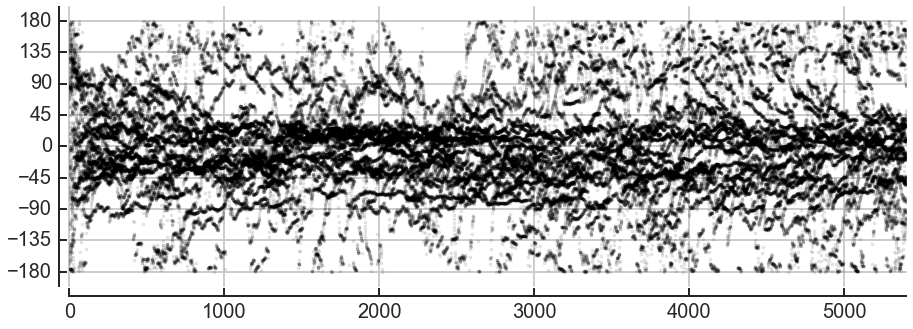

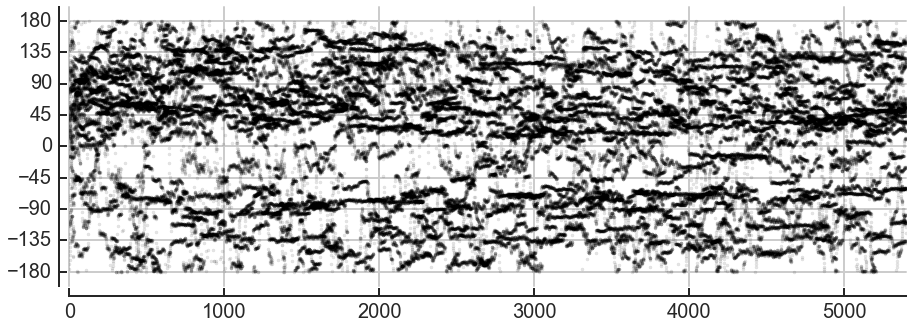

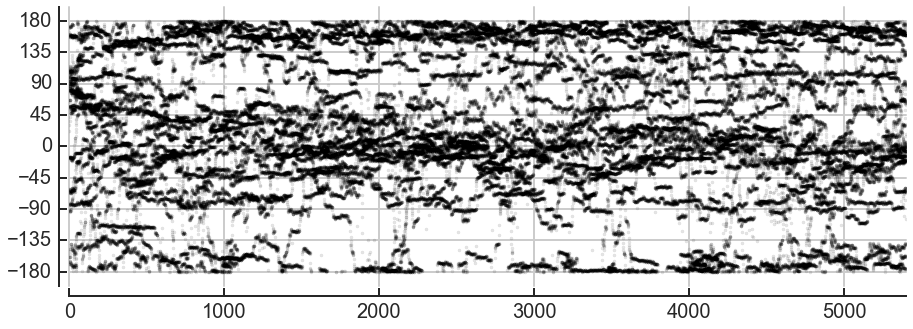

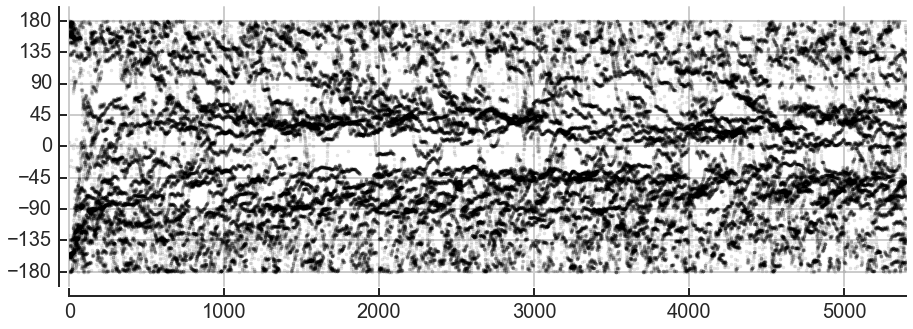

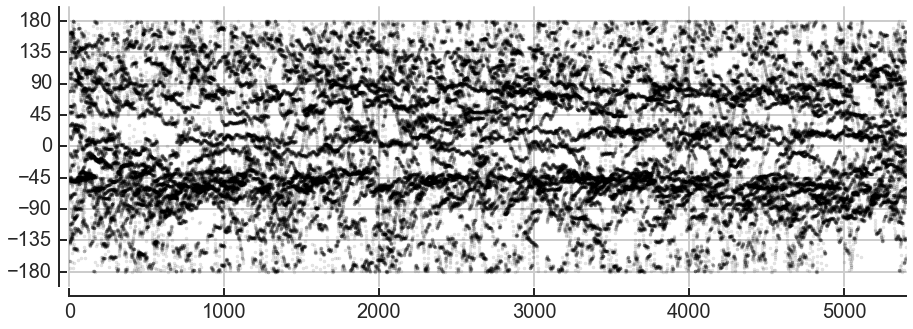

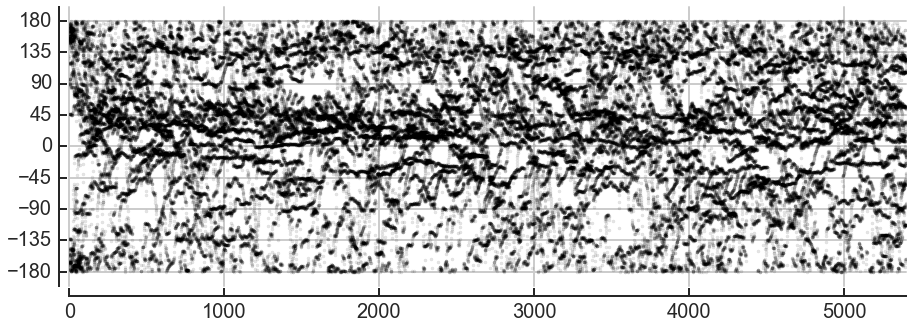

In [31]:
tp = [5,7,8,9,10,11]
bckclr_labels = ['darkseagreen', 'lavender','lightyellow']
myc = ["red", "medium green", "denim blue"]
for j in range(len(tp)):
    fig, ax1 = plt.subplots(1,1,figsize=(15, 5))
    for i in range(len(allangles_vf)): 
        p = allangles_vf[i][all_start_frames_m[i][tp[j]]:all_end_frames_m[i][tp[j]]]
        #ax1.plot((0,5400), (0, 0), 'red', linewidth= 2)
#         if j in [1,4]:
#             ax1.plot((0,5400), (0, 0), 'yellow', linewidth= 4)
#         else:
#             pass
        mycolor = list(np.random.choice(range(256), size=3))
        plt.scatter(np.arange(len(p)), p, c=sns.xkcd_rgb['black'], alpha=0.1, s=10)#,'k',alpha= 0.5)
            #ax1.set_title('speed = '+ p_labels[j]+' pixels/s',fontsize = 20, fontweight='bold')
        ax1.set_ylim([-200, 200])
        ax1.set_xlim([0, (len(p))])
#         ax1.set_xticks(np.arange(0, 5401, 1800))
        ax1.set_yticks(np.arange(-180, 225,45))
        ax1.yaxis.set_tick_params(labelsize=20)
        ax1.xaxis.set_tick_params(labelsize=20)
            #ax1.set_xticklabels((round(all_start_frames[j]/30),round(all_end_frames[j+1]/30)))
            #box, ticks format
        sns.set_style("ticks")
        sns.despine()
        ax1.tick_params(direction='in', length=8, width=2)
        sns.despine(offset=10, trim=False);
        ax1.spines['left'].set_linewidth(2)
        ax1.spines['bottom'].set_linewidth(2)
        ax1.grid(True,linewidth=2)
        
#         if j in [0,3]:
#             ax1.patch.set_facecolor(bckclr_labels[0])
#         elif j in [1,4]:
#             ax1.patch.set_facecolor(bckclr_labels[1])
#         elif j in [2,5]:
#             ax1.patch.set_facecolor(bckclr_labels[2])            
        ax1.patch.set_alpha(0.7)

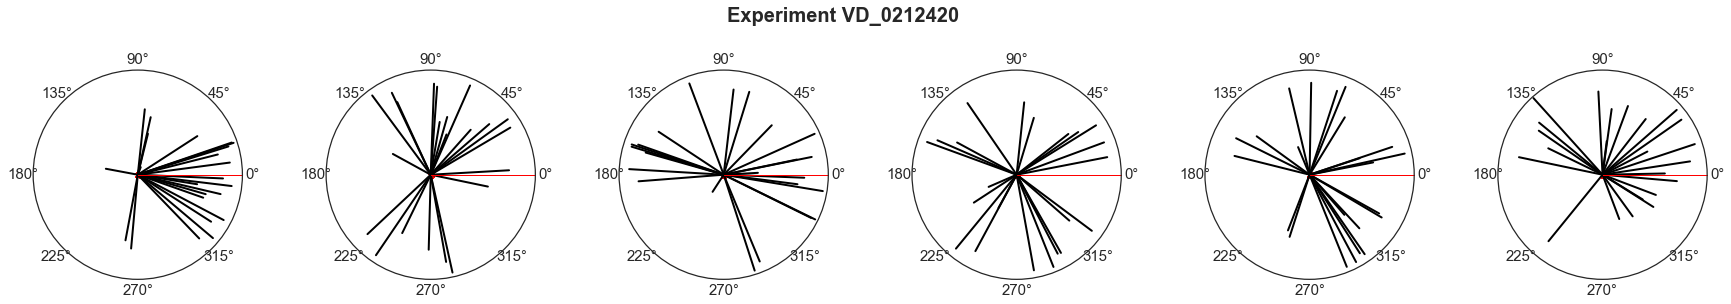

In [33]:
# # circular means plot
tp = [5,7,8,9,10,11]

sns.set_style("ticks")
fig, axs = plt.subplots(1,6, figsize=(30, 5), facecolor='w', edgecolor='k', subplot_kw=dict(polar=True))
fig.subplots_adjust(hspace = .1, wspace = .4)
fig.suptitle('Experiment '+exp,fontsize = 20, fontweight='bold')

axs = axs.ravel()


axisorder = [0,1,2,3,4,5]
bckclr_labels = ['darkseagreen', 'lavender','lightyellow']

for j in range(len(tp)):
    for i in range(len(all_circmeans_vf)):

        cms = all_circmeans_vf[i][tp[j]]
        cvs = all_circvars_vf[i][tp[j]]
#         cms = all_circmeans_vf[i][j+5]
#         cvs = all_circvars_vf[i][j+5]

        axs[axisorder[j]].plot((0, cms), ( 0, cvs), alpha = 1, linewidth = 2, color = 'k')
        #a=np.deg2rad(all_pat_angles_vd[i][all_idxs_sorted[i][j]])

        axs[axisorder[j]].plot((0, 0), ( 0, 1), alpha = 0.99, color = 'r', linewidth = 1)
        #axs[axisorder[j]].plot((0, a), ( 0, 1), alpha = 0.9, color = 'r', linewidth =2)
        axs[axisorder[j]].grid(False)
        axs[axisorder[j]].set_yticks([])
        #axs[axisorder[j]].set_xticks([])
        axs[axisorder[j]].spines['polar'].set_visible(True)
        axs[axisorder[j]].set_rlim(0,1) 
        #axs[axisorder[j]].set_title(sun_intensities_tp[j],fontsize = 15, fontweight='bold')
        axs[axisorder[j]].xaxis.set_tick_params(labelsize=15, pad=10)
#         if j in [0,3]:
#             axs[axisorder[j]].patch.set_facecolor(bckclr_labels[0])
#         elif j in [1,4]:
#             axs[axisorder[j]].patch.set_facecolor(bckclr_labels[1])
#         elif j in [2,5]:
#             axs[axisorder[j]].patch.set_facecolor(bckclr_labels[2])            
        
        axs[axisorder[j]].patch.set_alpha(0.7)
            
        axs[axisorder[j]].scatter((0, 0), ( 0, 0), alpha = 1, linewidth =2, color = 'r', marker = 'x')

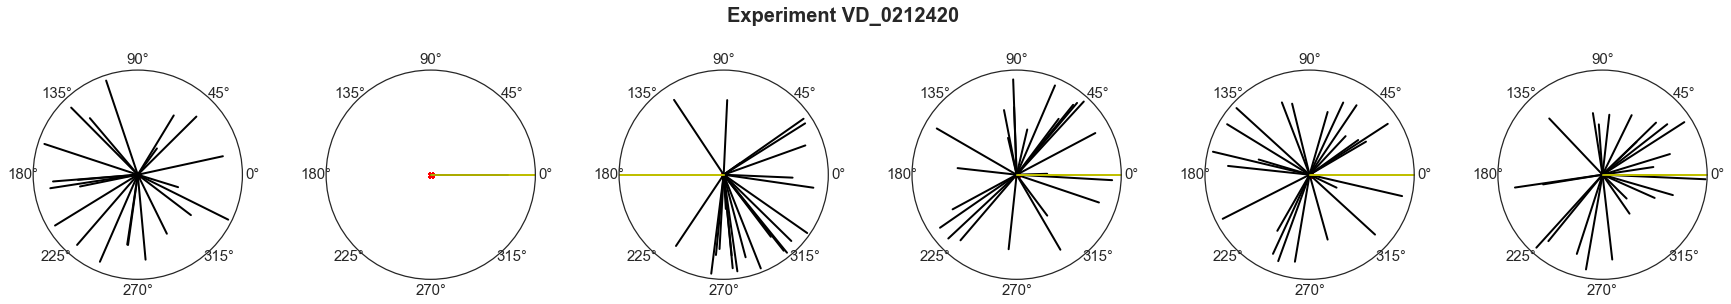

In [38]:
# # circular means plot
tp = [5,7,8,9,10,11]

sns.set_style("ticks")
fig, axs = plt.subplots(1,6, figsize=(30, 5), facecolor='w', edgecolor='k', subplot_kw=dict(polar=True))
fig.subplots_adjust(hspace = .1, wspace = .4)
fig.suptitle('Experiment '+exp,fontsize = 20, fontweight='bold')

axs = axs.ravel()


axisorder = [0,1,2,3,4,5,6]
bckclr_labels = ['darkseagreen', 'lavender','lightyellow']

for j in range(len(tp)):
    for i in range(len(all_circmeans_vf)):

        cms = all_circmeans_s1f[i][tp[j]]
        cvs = all_circvars_s1f[i][tp[j]]
#         cms = all_circmeans_vf[i][j+5]
#         cvs = all_circvars_vf[i][j+5]

        axs[axisorder[j]].plot((0, cms), ( 0, cvs), alpha = 1, linewidth = 2, color = 'k')
        

        #axs[axisorder[j]].plot((0, 0), ( 0, 1), alpha = 0.99, color = 'r', linewidth = 1)
        if j ==2:
            a=np.deg2rad(180)
            axs[axisorder[j]].plot((0, a), ( 0, 1), alpha = 0.9, color = 'y', linewidth =2)
        elif j ==0:
            pass
        else:
            a=np.deg2rad(0)
            axs[axisorder[j]].plot((0, a), ( 0, 1), alpha = 0.9, color = 'y', linewidth =2)
        #axs[axisorder[j]].plot((0, a), ( 0, 1), alpha = 0.9, color = 'y', linewidth =2)
        axs[axisorder[j]].grid(False)
        axs[axisorder[j]].set_yticks([])
        #axs[axisorder[j]].set_xticks([])
        axs[axisorder[j]].spines['polar'].set_visible(True)
        axs[axisorder[j]].set_rlim(0,1) 
        #axs[axisorder[j]].set_title(sun_intensities_tp[j],fontsize = 15, fontweight='bold')
        axs[axisorder[j]].xaxis.set_tick_params(labelsize=15, pad=10)
#         if j in [0,3]:
#             axs[axisorder[j]].patch.set_facecolor(bckclr_labels[0])
#         elif j in [1,4]:
#             axs[axisorder[j]].patch.set_facecolor(bckclr_labels[1])
#         elif j in [2,5]:
#             axs[axisorder[j]].patch.set_facecolor(bckclr_labels[2])            
        
        axs[axisorder[j]].patch.set_alpha(0.7)
            
        axs[axisorder[j]].scatter((0, 0), ( 0, 0), alpha = 1, linewidth =2, color = 'r', marker = 'x')

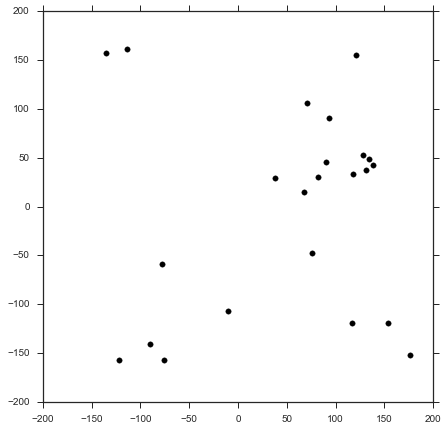

In [41]:
#plot heading correlation between 2 trials

bckclr_labels = ['darkseagreen', 'lavender','lightyellow']
for j in [1]:#range(len(all_idxs_sorted[0])):
    fig, ax1 = plt.subplots(1,1,figsize=(7, 7))
    for i in range(len(allangles_vf)): 

        cms1 = np.rad2deg(all_circmeans_sf[i][tp[j]])
        cms2 = np.rad2deg(all_circmeans_sf[i][tp[j+1]]) 
        
        ax1.scatter(cms1, cms2, s=30, color='k')
        
#         cms11 = np.rad2deg(all_circmeans_vf[i][all_idxs_sorted[i][j]])
#         cms22 = np.rad2deg(all_circmeans_vf[i][all_idxs_sorted[i][j+2]]) 
        
#         print(cms11, cms22, i, j)
#         ax1.scatter(cms11, cms22, s=30, color='b')
        
        ax1.set_ylim([-200, 200])
        ax1.set_xlim([-200, 200])        
        
#         ax1.set_xlim([0, (len(p))])
#         ax1.set_xticks(np.arange(0, 5401, 1800))
#         ax1.set_yticks(np.arange(-180, 225,45))
#         ax1.yaxis.set_tick_params(labelsize=20)
#         ax1.xaxis.set_tick_params(labelsize=20)
#             #ax1.set_xticklabels((round(all_start_frames[j]/30),round(all_end_frames[j+1]/30)))
#             #box, ticks format
#         sns.set_style("ticks")
#         sns.despine()
#         ax1.tick_params(direction='in', length=8, width=2)
#         sns.despine(offset=10, trim=False);
#         ax1.spines['left'].set_linewidth(2)
#         ax1.spines['bottom'].set_linewidth(2)
#         ax1.grid(True,linewidth=2)
        
#         if j in [0,3]:
#             ax1.patch.set_facecolor(bckclr_labels[0])
#         elif j in [1,4]:
#             ax1.patch.set_facecolor(bckclr_labels[1])
#         elif j in [2,5]:
#             ax1.patch.set_facecolor(bckclr_labels[2])            
#         ax1.patch.set_alpha(0.7)
        
#         #ax1.set_title(sun_intensities_tp[j],fontsize = 15, fontweight='bold')

In [ ]:
# #exp dependant - sort trials depending on WF
# #180 deg, wf: 0, 0.5, 1.0, 2.0
# #90 deg, wf: 0, 0.5, 1.0, 2.0

# # print(all_pat_angles_vd[0])
# # print(all_alicat_set_points[0])

# trials_to_be_sorted=[5,6,7,8,9,10,11,12]

# #exp dependant
# #sorted like this:
# #90 deg, wf: 0, 0.5, 1.0, 2.0
# #180 deg, wf: 0, 0.5, 1.0, 2.0

# all_idxs_sorted = []
# for i in range(len(all_pat_angles_vd)):
#     all_pat_angles_vd_s = all_pat_angles_vd[i][5:]
#     all_alicat_set_points_s = all_alicat_set_points[i][5:]

#     sorted_trials1 = []
#     sorted_trials2 = []
#     sorted_trials3 = []
#     sorted_trials4 = []
#     sorted_trials5 = []
#     sorted_trials6 = []
#     sorted_trials7 = []
#     sorted_trials8 = []
    
#     for j in range(len(all_pat_angles_vd_s)):
#         if all_pat_angles_vd_s[j] == 90 and all_alicat_set_points_s[j] == 0.0:
#             sorted_trials1.append(j+5)

#         elif all_pat_angles_vd_s[j] == 90 and all_alicat_set_points_s[j] == 0.5:  
#             sorted_trials2.append(j+5)

#         elif all_pat_angles_vd_s[j] == 90 and all_alicat_set_points_s[j] == 1.0:  
#             sorted_trials3.append(j+5)

#         elif all_pat_angles_vd_s[j] == 90 and all_alicat_set_points_s[j] >= 1.3:  
#             sorted_trials4.append(j+5)

#         elif all_pat_angles_vd_s[j] == 180 and all_alicat_set_points_s[j] == 0.0:
#             sorted_trials5.append(j+5)

#         elif all_pat_angles_vd_s[j] == 180 and all_alicat_set_points_s[j] == 0.5:  
#             sorted_trials6.append(j+5)

#         elif all_pat_angles_vd_s[j] == 180 and all_alicat_set_points_s[j] == 1.0:  
#             sorted_trials7.append(j+5)

#         elif all_pat_angles_vd_s[j] == 180 and all_alicat_set_points_s[j] >= 1.3:  
#             sorted_trials8.append(j+5)
        
#         #first list is the control 1 min trials at start of exp
#         sorted_trials = ([0,1,2,3],sorted_trials1,sorted_trials2,sorted_trials3,sorted_trials4,
#                             sorted_trials5,sorted_trials6,sorted_trials7,sorted_trials8)
        
#         sorted_trials_flat_list = [item for sublist in sorted_trials for item in sublist]
        
#     all_idxs_sorted.append(sorted_trials_flat_list)

# print(all_idxs_sorted)